In [ ]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import Dataset, DataLoader

from torchvision import transforms as tfs

from matplotlib.colors import ListedColormap

In [ ]:
def open_to_tensor(path, max_size=None):
    image = Image.open(path)
    w, h = image.size
    print(w, h)
    k = 32
    w -= w % k
    h -= h % k
    if max_size:
        w, h = max_size
    size = (0, 0, w, h)
    image = image.crop(size)
    image = ToTensor()(image)
    image = torch.unsqueeze(image, 0)
    print(image.shape)
    return image


In [108]:
import os
import pandas as pd
from torchvision.io import read_image
from pathlib import Path
import imagesize
from dataclasses import dataclass
from PIL import Image
from torchvision.transforms import ToTensor


@dataclass(init=True, eq=True)
class Rectangle:
    x: int
    y: int
    width: int
    height: int
        
class InriaImageDataset(Dataset):
    def __init__(
        self, 
        base_path, 
        img_dir, 
        label_dir, 
        transform=None, 
        target_transform=None, 
        max_size=None, 
        size_floor=True
    ):
        self.base_path = Path(base_path)
        print('Preparing dataset in', self.base_path)
        self.img_dir = self.base_path / img_dir
        print('Images directory', self.img_dir)
        self.label_dir = self.base_path / label_dir
        print('Labels directory', self.label_dir)
        self.transform = transform
        self.target_transform = target_transform
        self.max_size = max_size
        
        image_names = os.listdir(self.img_dir)
        label_names = os.listdir(self.label_dir)
        assert image_names == label_names
        print('Total images =', len(image_names))
        
        self.image_names = image_names

        self.index_to_image_and_rect = []

        for img_name in self.image_names:
            width, height = imagesize.get(self.img_dir / img_name)
            if max_size:
                max_width, max_height = max_size
            else:
                max_width, max_height = width, height

            for wi in range(width // max_width):
                for hi in range(height // max_height):
                    rect = Rectangle(x=wi*max_width, y=hi*max_height, width=max_width, height=max_height)
                    self.index_to_image_and_rect.append((img_name, rect))
            # todo % rest
        
        print('Total crops =', len(self.index_to_image_and_rect))
            
        
    def __len__(self):
        return len(self.index_to_image_and_rect)
    
    def read_image(self, path, crop_rect):
        image = Image.open(path)
        size = (crop_rect.x, crop_rect.y, crop_rect.x + crop_rect.width, crop_rect.y + crop_rect.height)
        image = image.crop(size)
        image = ToTensor()(image)
#         image = torch.unsqueeze(image, 0)
        return image

    def get_image_name_by_idx(self, idx):
        img_name, rect = self.index_to_image_and_rect[idx]
        return img_name

    def __getitem__(self, idx):
        img_name, rect = self.index_to_image_and_rect[idx]
        img_path = self.img_dir / img_name
        label_path = self.label_dir / img_name
        image = self.read_image(img_path, rect)
        label = self.read_image(label_path, rect)
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [113]:
import time
start = time.time()

k = 2
max_size=(256 * k, 256 * k)
print('Using max_size =', max_size)
train_dataset = InriaImageDataset("/home/s0011/data_inria/train", img_dir="images", label_dir="gt", max_size=max_size)
test_dataset = InriaImageDataset("/home/s0011/data_inria/validation", img_dir="images", label_dir="ground_truth", max_size=max_size)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

end = time.time()
print("Preparing time", end - start)

Using max_size = (512, 512)
Preparing dataset in /home/s0011/data_inria/train
Images directory /home/s0011/data_inria/train/images
Labels directory /home/s0011/data_inria/train/gt
Total images = 180
Total crops = 14580
Preparing dataset in /home/s0011/data_inria/validation
Images directory /home/s0011/data_inria/validation/images
Labels directory /home/s0011/data_inria/validation/ground_truth
Total images = 25
Total crops = 2025
Preparing time 0.0870199203491211


In [154]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


for cmap in [
    plt.get_cmap(), plt.get_cmap('turbo'), *[plt.get_cmap(n) for n in ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r']]
]:
    ncolors = 256
    color_array = cmap(range(ncolors))
    color_array[:,-1] = np.linspace(0.0,1.0,ncolors)
    map_object = LinearSegmentedColormap.from_list(name=f'transparent_{cmap.name}',colors=color_array)
    plt.register_cmap(cmap=map_object)


cmap = plt.get_cmap()
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)
my_cmap = ListedColormap(my_cmap)

def tensor_to_image(t):
    return t.permute(2,1,0).squeeze()

def plot_lineup(im, ms, gt, figsize=None, ax=None):
    if not figsize:
        figsize = (20,20)
    if not ax:
        fig, ax = plt.subplots(figsize = figsize)

    img = ax.imshow(im, interpolation='nearest', origin='lower')
    img = ax.imshow(gt,
                    interpolation='nearest', 
                    origin='lower', 
                    alpha=0.5, 
                    cmap='transparent_viridis')
    img = ax.imshow(ms, 
                    interpolation='nearest', 
                    alpha=0.5, 
                    origin='lower',
                    cmap='transparent_BuPu',
                   )
    
def dataset_samples(dataset):
    print("Dataset size =", len(dataset))
    figure = plt.figure(figsize=(20, 20))
    cols, rows = 2, 2
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        img, label = dataset[sample_idx]
        name = dataset.get_image_name_by_idx(sample_idx)
        figure.add_subplot(rows, cols, i)
        plt.imshow(tensor_to_image(img), interpolation='nearest', origin='lower')
        plt.imshow(tensor_to_image(label), interpolation='nearest', alpha=0.5, origin='lower', cmap=my_cmap)
        plt.title(name)
    plt.show()

Dataset size = 14580


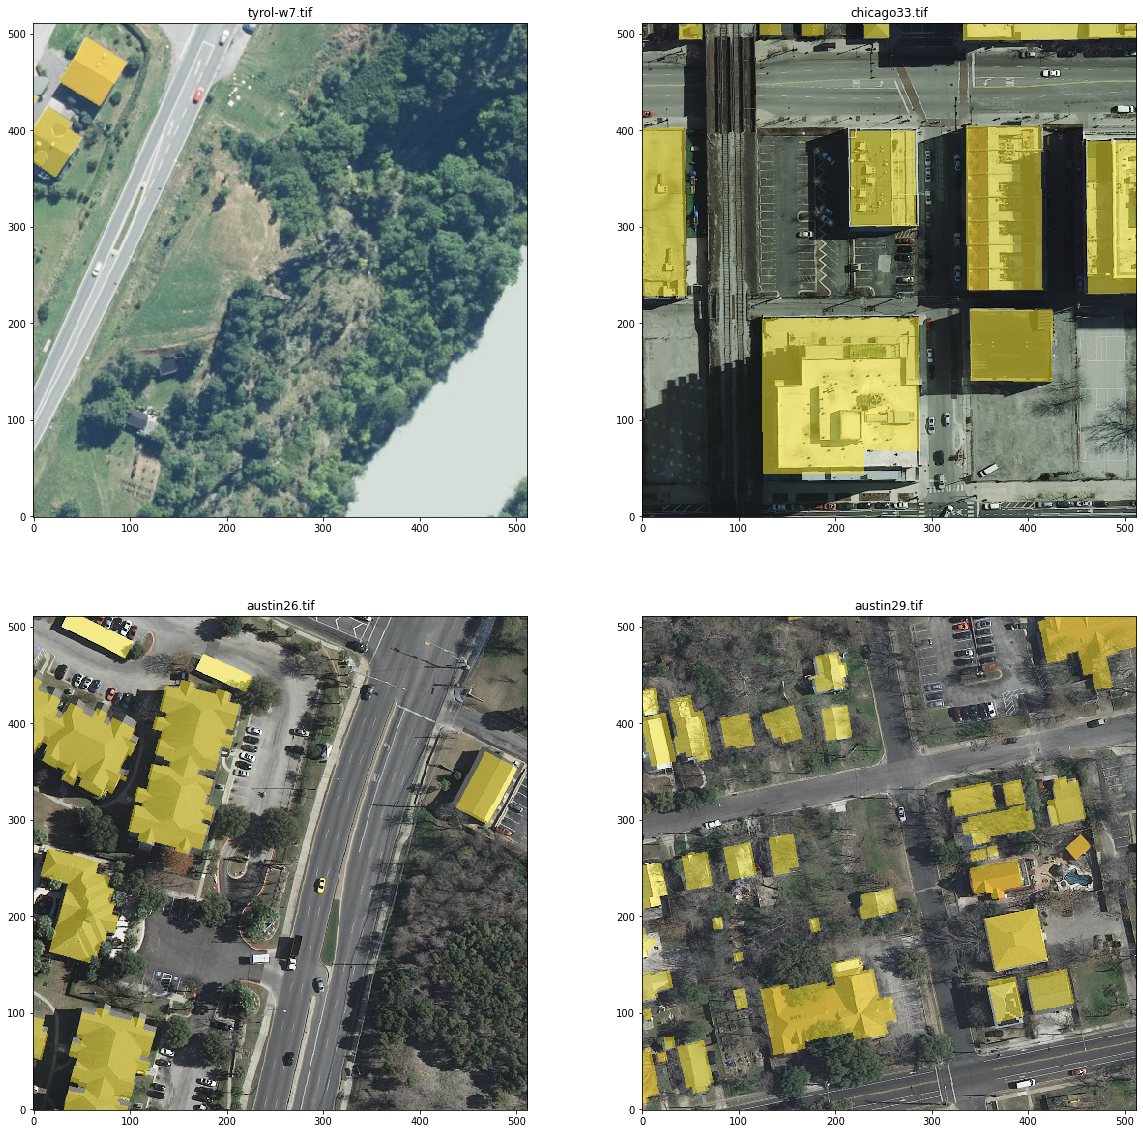

In [111]:
dataset_samples(train_dataset)

Dataset size = 2025


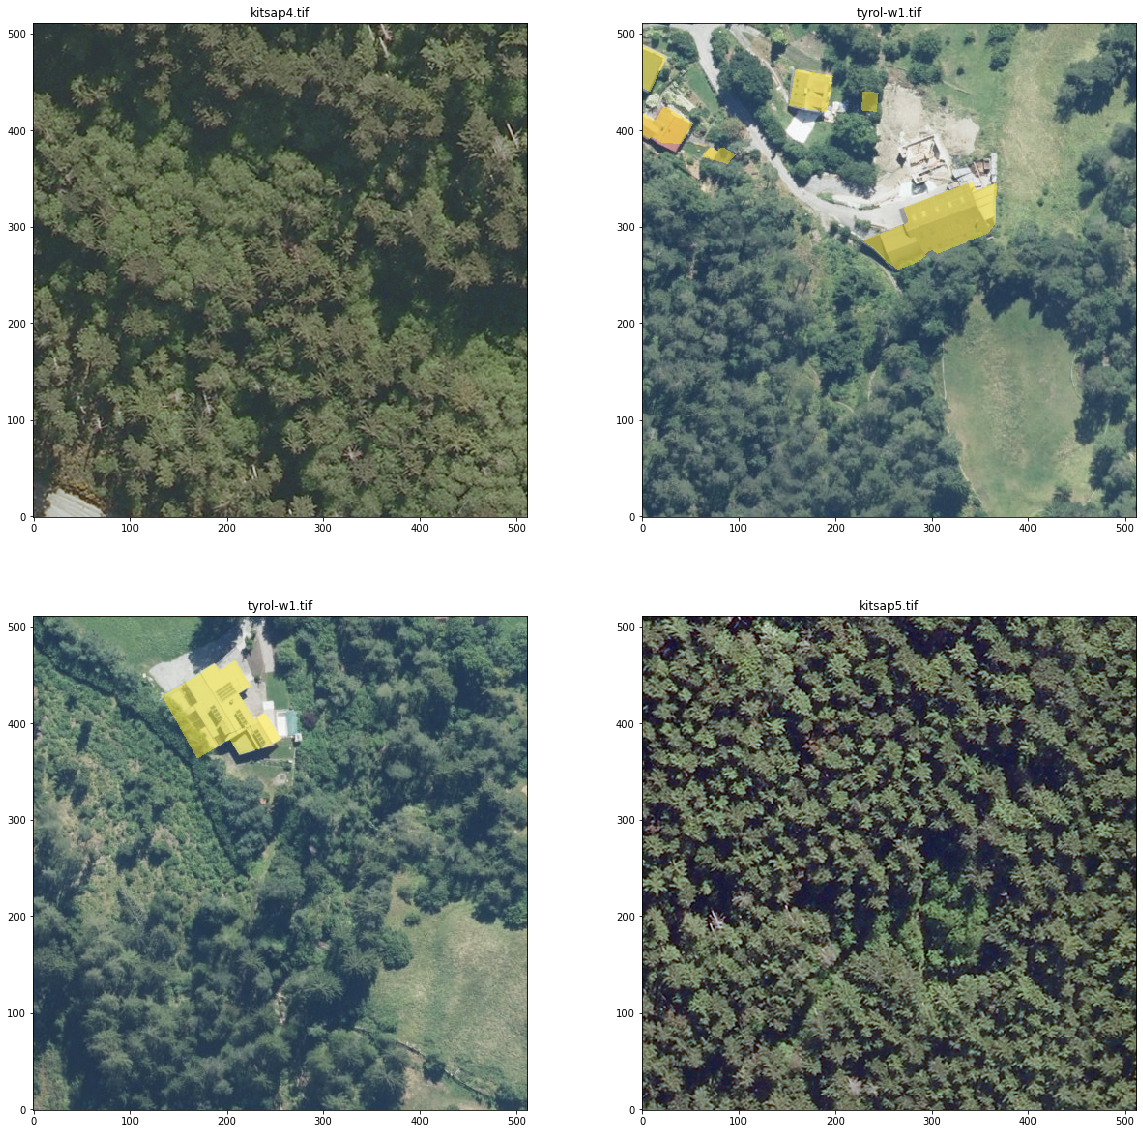

In [112]:
dataset_samples(test_dataset)

Feature batch shape: torch.Size([8, 3, 512, 512])
Labels batch shape: torch.Size([8, 1, 512, 512])


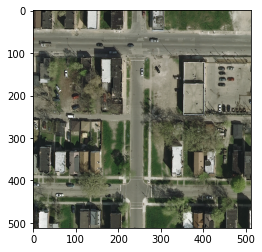

Label: tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.]]])


In [121]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(tensor_to_image(img), cmap="gray")
plt.show()
print(f"Label: {label}")

# Model

In [169]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
       
        #Encoder
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
       
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 3, 2, stride=2)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.t_conv1(x))
        x = F.sigmoid(self.t_conv2(x))
              
        return x
    
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
)


In [171]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "test": test_dataloader}

In [181]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

Tesla K40m
Memory Usage:
Allocated: 0.0 GB
Cached:    0.2 GB


In [177]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)
model.to(device)

cuda:0


ConvAutoencoder(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
)

In [176]:
for param in model.parameters():
    print(type(param.data), param.size())


<class 'torch.Tensor'> torch.Size([16, 3, 3, 3])
<class 'torch.Tensor'> torch.Size([16])
<class 'torch.Tensor'> torch.Size([4, 16, 3, 3])
<class 'torch.Tensor'> torch.Size([4])
<class 'torch.Tensor'> torch.Size([4, 16, 2, 2])
<class 'torch.Tensor'> torch.Size([16])
<class 'torch.Tensor'> torch.Size([16, 3, 2, 2])
<class 'torch.Tensor'> torch.Size([3])


In [ ]:
n_epochs = 100

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0

    #Training
    for data in train_dataloader:
        images, _ = data
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
          
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))


In [ ]:
max_epochs = 1
accuracy = {"train": [], "test": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                 # Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                # Set model to ``eval`` mode and calculate outputs
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            print(preds)
            correct = sum(preds == y_batch) # суммируем bool True == 1; False == 0
            all = len(preds)
            epoch_correct += correct
            epoch_all += all
            if k == "train":
                # Calculate gradients and make a step of your optimizer
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()

        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


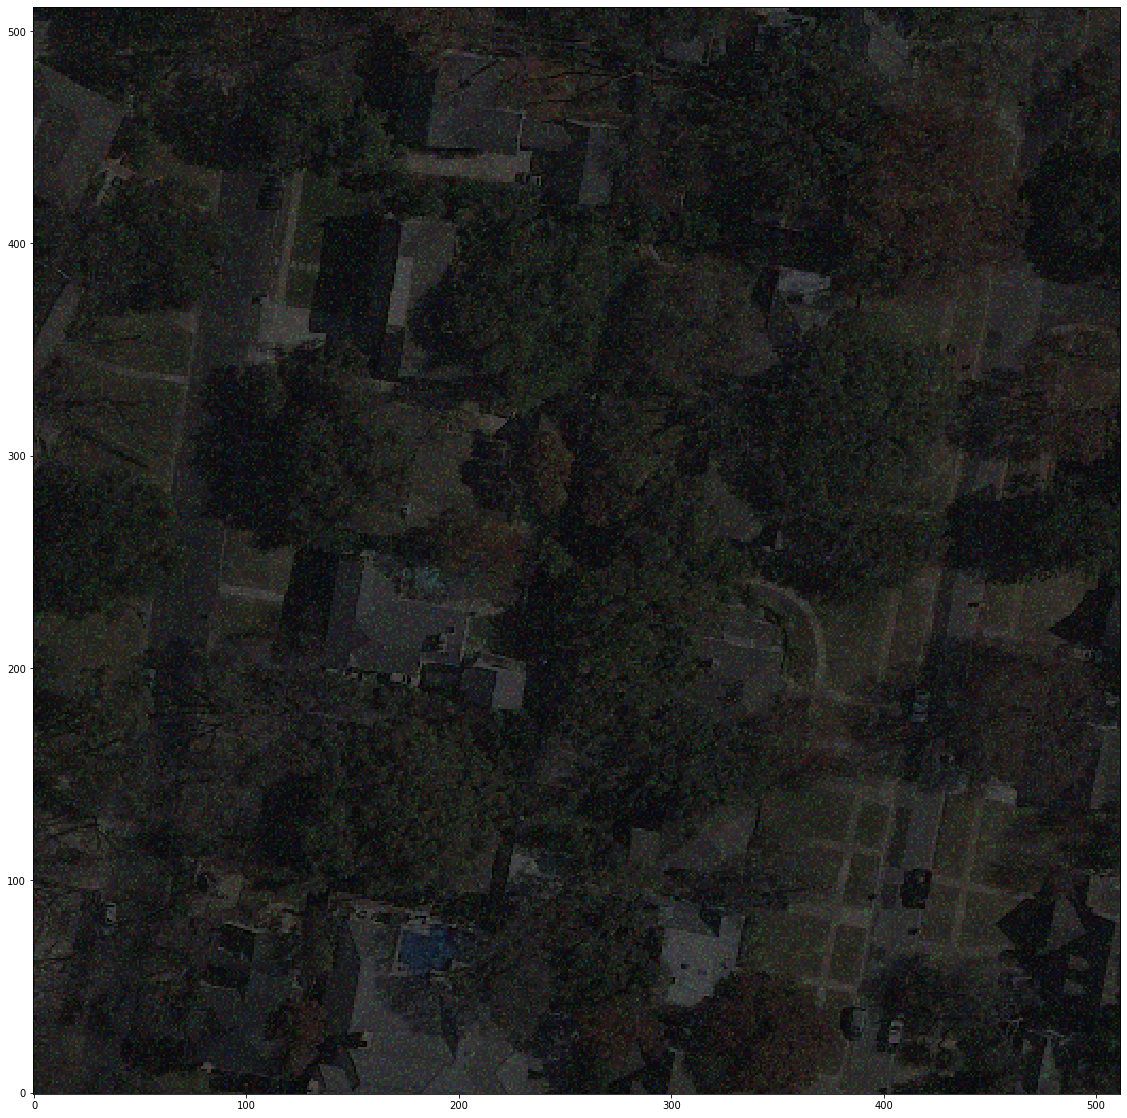

In [165]:
for k, dataloader in loaders.items():
    for x_batch, y_batch in dataloader:
        with torch.no_grad():
            out = model(x_batch)
        plot_lineup(
            tensor_to_image(x_batch[0]), 
            tensor_to_image(out[0].view(-1, w, h)), 
            tensor_to_image(out[0].view(-1, w, h)), 
#             tensor_to_image(y_batch[0]),
        )
        break
    break
        